# Create an interactive spectral plot of a timeseries
## Pick a location, pick a data range, go!
### (sort of)

The goal of this notebook is to guide you through creating a spectral plot for surface reflectance anywhere in the world. This process includes loading PACE spectral data through Earch Access, trimming it to a region in time and space, manipulating x-arrays, and plotting an interactive plot.

### First step is loading in dependancies:

In [29]:
import os
import earthaccess
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from datetime import datetime
import pandas as pd
import plotly.graph_objects as go

### Next step is to log in to EarthAccess to downlaod PACE data from the Ocean Biology DAAC (OB.DAAC)

You can follow this tutorial for more information:

In [30]:
auth = earthaccess.login()
# are we authenticated?
if auth.authenticated:
    print("authenticated!")
if not auth.authenticated:
    # ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

authenticated!


In [31]:
results = earthaccess.search_datasets(instrument="oci")

### If you want to select different products, you can search for other short name products here:

In [32]:
for item in results:
    summary = item.summary()
    print(summary["short-name"])

PACE_OCI_L2_BGC_NRT
PACE_OCI_L0_SCI
PACE_OCI_L1A_SCI
PACE_OCI_L1B_SCI
PACE_OCI_L1C_SCI
PACE_OCI_L2_AOP_NRT
PACE_OCI_L2_IOP_NRT
PACE_OCI_L2_PAR_NRT
PACE_OCI_L3B_CHL_NRT
PACE_OCI_L3B_IOP_NRT
PACE_OCI_L3B_KD_NRT
PACE_OCI_L3B_PAR_NRT
PACE_OCI_L3B_POC_NRT
PACE_OCI_L3B_RRS_NRT
PACE_OCI_L3M_CHL_NRT
PACE_OCI_L3M_IOP_NRT
PACE_OCI_L3M_KD_NRT
PACE_OCI_L3M_PAR_NRT
PACE_OCI_L3M_POC_NRT
PACE_OCI_L3M_RRS_NRT


In [33]:
difcb=pd.read_csv("https://github.com/oceanhackweek/ohw24_proj_pace_us/raw/main/contributor_folders/Gulce/mvco_difcb_data.csv")


# Assuming difcb is your DataFrame and the 'date' column is already in datetime format
# Convert the date column to datetime if it isn't already
difcb['date'] = pd.to_datetime(difcb['date'], format='%Y-%m-%d')  # Adjust format as needed


In [26]:
difcb['date']

0      2024-07-01
1      2024-07-01
2      2024-07-01
3      2024-07-01
4      2024-07-01
          ...    
2272   2024-07-17
2273   2024-07-17
2274   2024-07-17
2275   2024-07-17
2276   2024-07-17
Name: date, Length: 2277, dtype: datetime64[ns]

In [34]:
lon_max = difcb['longitude'].max()
lon_min = difcb['longitude'].min()
lat_max = difcb['latitude'].max()
lat_min = difcb['latitude'].min()

### Here we are focusing on the area off Long Island in July, so we set our bounding box and date range

In [35]:
tspan = ("2024-07-01", "2024-08-25")
bbox = (lon_min, lat_min, lon_max, lat_max)

In [36]:
results = earthaccess.search_data(
    short_name="PACE_OCI_L3M_RRS_NRT",
    temporal=tspan,
    bounding_box=bbox,
    granule_name="*.DAY.*.0p1deg.*",
)

### Here we pull out two groups of data, bounding our bloom

In [37]:
paths = earthaccess.open(results)[0:20]

QUEUEING TASKS | :   0%|          | 0/56 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/56 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/56 [00:00<?, ?it/s]

Check what is in the paths object to be sure it is formatted correctly.

In [38]:
paths

[<File-like object HTTPFileSystem, https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240701.L3m.DAY.RRS.V2_0.Rrs.0p1deg.NRT.nc>,
 <File-like object HTTPFileSystem, https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240702.L3m.DAY.RRS.V2_0.Rrs.0p1deg.NRT.nc>,
 <File-like object HTTPFileSystem, https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240703.L3m.DAY.RRS.V2_0.Rrs.0p1deg.NRT.nc>,
 <File-like object HTTPFileSystem, https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240704.L3m.DAY.RRS.V2_0.Rrs.0p1deg.NRT.nc>,
 <File-like object HTTPFileSystem, https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240705.L3m.DAY.RRS.V2_0.Rrs.0p1deg.NRT.nc>,
 <File-like object HTTPFileSystem, https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20240706.L3m.DAY.RRS.V2_0.Rrs.0p1deg.NRT.nc>,
 <File-like object HTTPFileSystem, https://obdaac-tea.earthdatac

### Open and Combine datasets, preserving date information

Here we open each dataset, in this case each day, and combine them into one x-array. We also pull the date for each layer, and add them in as coordinates.
We also get the average reflectance value at each wavelength across the range of our bounding box, resulting in a single spectrum for each day.

In [39]:


# Use dask for lazy loading
combined_datasets = []
dates = []

# Iterate over all the datasets
for i in range(1, len(paths)):
    # Open dataset without specifying chunks
    dataset = xr.open_dataset(paths[i])

    # Rechunk the dataset after loading
    dataset = dataset.chunk({'lon': 'auto', 'lat': 'auto'})  # Use 'auto' or set specific sizes
    
    # Subset the dataset within the specified region and append to list
    subset = dataset.sel(lon=slice(-159.5, -157.5), lat=slice(27.5, 26))

    # Extract the date and convert to datetime
    date = subset.attrs['time_coverage_start']
    date = datetime.fromisoformat(date.replace("_", "T"))  # Convert to datetime

    # Append the subset to the list of datasets
    combined_datasets.append(subset)
    
    # Keep track of the dates separately
    dates.append(date)

# Concatenate all subsets along a new dimension, e.g., 'dataset'
combined_dataset = xr.concat(combined_datasets, dim='dataset')

# Calculate the mean Rrs value across lon and lat for each dataset
average_per_dataset = combined_dataset.mean(dim=['lon', 'lat'])

# Add dates as a coordinate to the averaged dataset
average_per_dataset = average_per_dataset.assign_coords(datetime=('dataset', dates))


Check that our resulting array is properly formatted with lat, lon, wavelength, and datetime.

In [40]:
average_per_dataset

<xarray.Dataset>
Dimensions:     (wavelength: 184, dataset: 19, rgb: 3, eightbitcolor: 256)
Coordinates:
  * wavelength  (wavelength) float64 339.0 341.0 344.0 ... 714.0 717.0 719.0
    datetime    (dataset) object 2024-07-02T00:19:27+00:00 ... 2024-07-19T23:...
Dimensions without coordinates: dataset, rgb, eightbitcolor
Data variables:
    Rrs         (dataset, wavelength) float32 dask.array<chunksize=(1, 184), meta=np.ndarray>
    palette     (dataset, rgb, eightbitcolor) uint8 dask.array<chunksize=(1, 3, 256), meta=np.ndarray>

### Plotting
Next, we extract our desired plotting data: Reflectance, wavelength, and datetime. We use the plotly package to create the interactive plot.

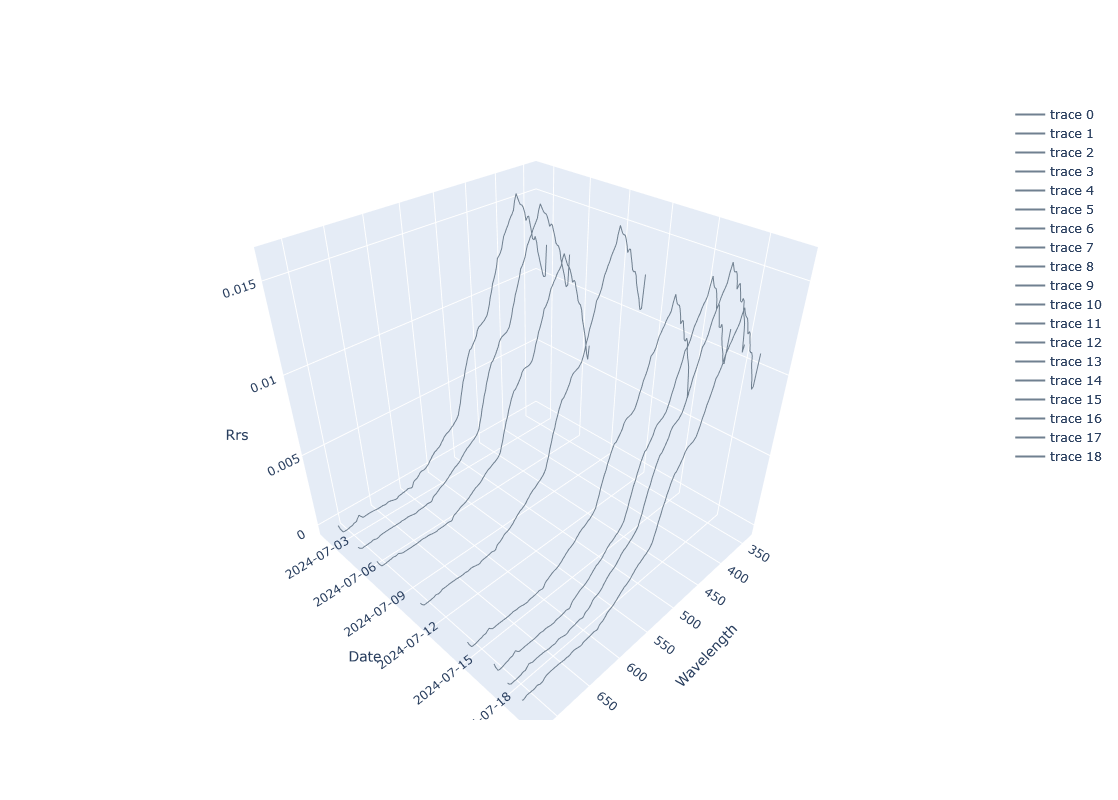

In [41]:


# Extract values for plotting
wavelengths = average_per_dataset['wavelength'].values
rrs_values = average_per_dataset['Rrs'].compute()
dates = average_per_dataset['datetime'].values

# Create a 3D scatter plot
fig = go.Figure()

for dataset_index in range(rrs_values.shape[0]):
    fig.add_trace(go.Scatter3d(
        x=wavelengths,
        y=[dates[dataset_index]] * len(wavelengths),  # Use the date for each dataset
        z=rrs_values[dataset_index],
        mode='lines',
        line=dict(color='slategray')
    ))

fig.update_layout(
    scene=dict(
        xaxis_title='Wavelength',
        yaxis_title='Date',
        zaxis_title='Rrs',
        yaxis=dict(
            tickformat='%Y-%m-%d',  # Format y-axis ticks as dates
            type='date'  # Ensure y-axis treats values as dates
        )
    ),
    width=1200,
    height=800,
)

fig.show()


## Case use: IFCB off the Long Island Coast

As an example, we have loaded in plankton genus distribution from an imaging lab off of Long Island, NY.
Here, we define a plotting function that takes a date and plots distribution for that date matching our spectral data.

In [42]:
## STEP 3.2
# Function to create and display a bar graph for a specific day
def display_genus_distribution(date):
    species_data = difcb[difcb['date'] == date]
    
    # Create and display the genus distribution plot
    plt.figure(figsize=(10, 6))
    plt.bar(species_data['genus'], species_data['count'])
    plt.yscale('log')
    plt.title(f"Genus Distribution on {date}", fontsize=16)
    plt.xlabel('Genus', fontsize=14)
    plt.ylabel('Count (log scale)', fontsize=14)
    plt.xticks(rotation=90)
    plt.show()




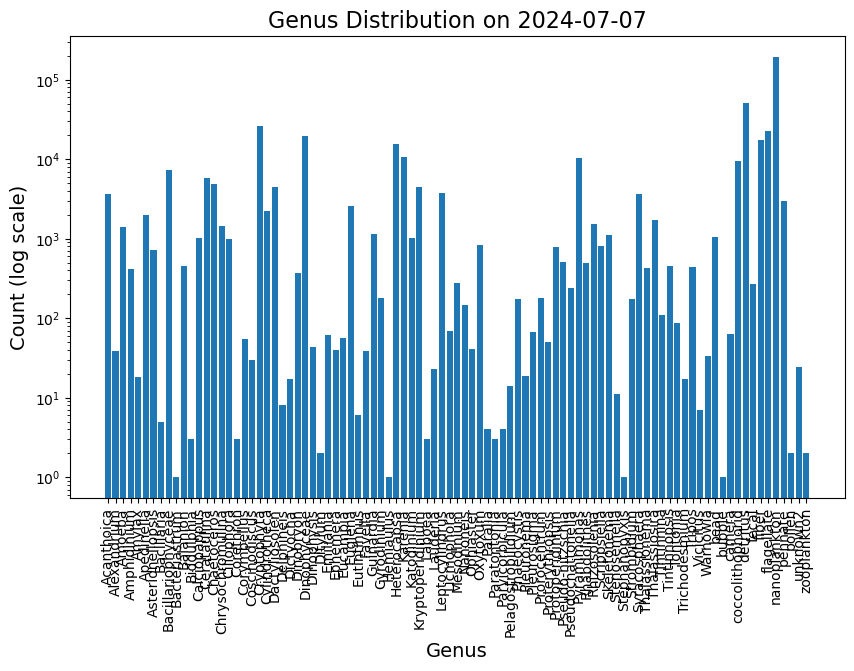

In [43]:
# Example usage:
# After identifying a date in the plot, such as "2024-07-01", you can manually call:
display_genus_distribution('2024-07-07') #in here you can CHANGE the datE to look at genus distribution